## Code Attribution

The code presented in this section, which generates dynamic spectra with varying pulse parameters, is the result of my work and has been adapted from Python notebooks authored by Joseph Kania. These notebooks utilized the WILL (Weighted Injector of Luminous Lighthouses) Python package.

### Code Author
- **Dirk Kuiper**

### Sources
The code has been adjusted and customized from the following sources:

- Joseph Kania's Python example notebooks, which provided the foundational code for generating dynamic spectra with pulses. These notebooks served as a valuable reference and inspiration for the implementation of the following code.

- The WILL (Weighted Injector of Luminous Lighthouses) Python package, which was used for several functions and utilities, enhancing the capabilities of the code.


## Show how we can inject a pulse into a GREENBURST filterbank.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from jess.dispersion import dedisperse
from jess.fitters import median_fitter
from scipy.stats import median_abs_deviation
from will import create, inject, detect
from simulate_frbs import *
from plotting import *
from draw_from_dist import *

## Creating a fresh filterbank file from scratch

Code adapted from: https://thepetabyteproject.github.io/your/0.6.6/ipynb/Writer/

I tried to make the header as consistent as possible with the Greenbank data from Zenodo, in case we will want to use it later to test with RFI etc.

In [3]:
# Create a filterbank with noise, std is such that the lightcurve will have std 1
create_filterbank_with_noise("output_with_noise__2.fil", std_value=np.sqrt(1.0/512), mean_value=0.0, num_frequency_channels=1000, num_time_samples=1024)

(1024, 1000)


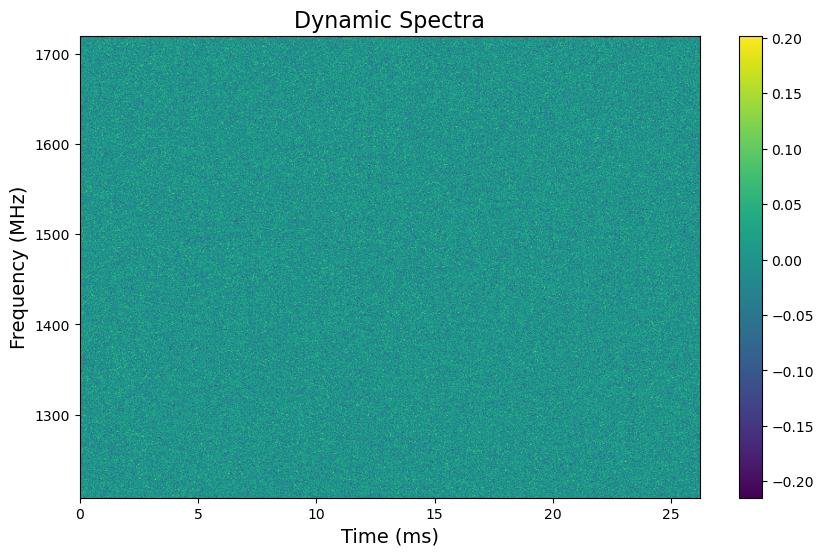

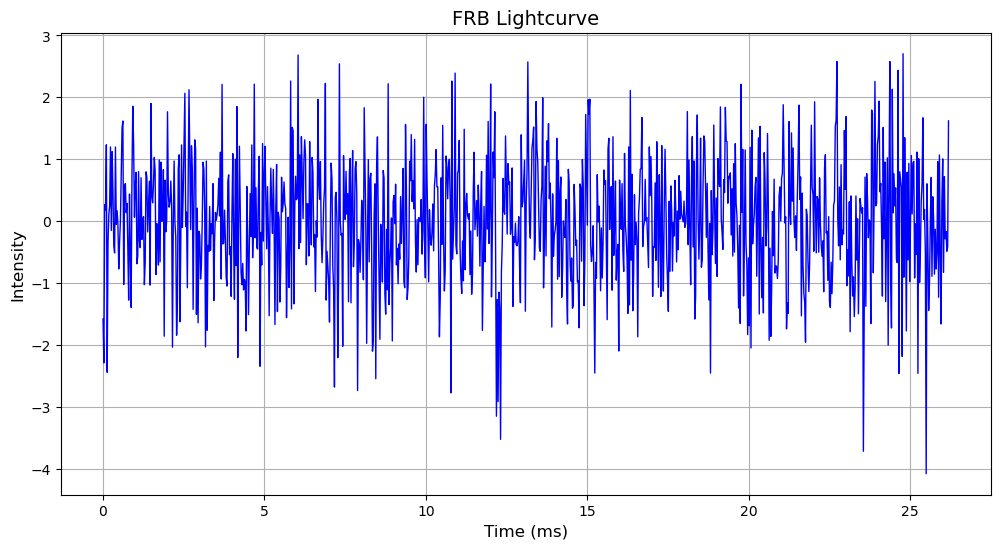

In [4]:
# Get the dynamic spectra from a filterbank file with 1024 time samples
dynamic_spectra, yr_obj = get_dynamic_spectra_from_filterbank(file_name='output_with_noise__2.fil', num_time_samples=1024)
print(dynamic_spectra.shape)

# Crop the dynamic spectra
dynamic_spectra = dynamic_spectra[:, 208:720]


# Plot the dynamic spectra
plot_dynamic_spectra(dynamic_spectra)

# Sum the dynamic spectra along the frequency axis to create a lightcurve
lightcurve = np.sum(dynamic_spectra, axis=1)

# Plot the lightcurve using time sample numbers as the x-axis
plot_lightcurve(lightcurve=lightcurve, time_samples=np.arange(1024))


## Create a simple Pulse

In [5]:
def generate_center_freq(min_freq, max_freq):
    """
    Generate a random frequency center within the specified range.

    Parameters:
        min_freq (float): Minimum frequency in MHz.
        max_freq (float): Maximum frequency in MHz.

    Returns:
        float: Random center frequency within the specified range.
    """
    center_freq = np.random.uniform(min_freq, max_freq)
    return center_freq

def generate_sigma_freq(min_sigma, max_sigma):
    """
    Generate a random frequency width (sigma_freq) within the specified range.

    Parameters:
        min_sigma (float): Minimum frequency width (sigma_freq).
        max_sigma (float): Maximum frequency width (sigma_freq).

    Returns:
        float: Random sigma_freq within the specified range.
    """
    sigma_freq = np.random.uniform(min_sigma, max_sigma)
    return sigma_freq

def generate_sigma_time(mean, std):
    """
    Generate a random time width (sigma_time) from a normal distribution within the specified range.

    Parameters:
        mean (float): Mean value of the normal distribution.
        std (float): Standard deviation of the normal distribution.

    Returns:
        float: Random sigma_time within the specified range.
    """
    sigma_time = np.random.normal(loc=mean, scale=std)
    return sigma_time



1558.5450015778495
(104, 512)


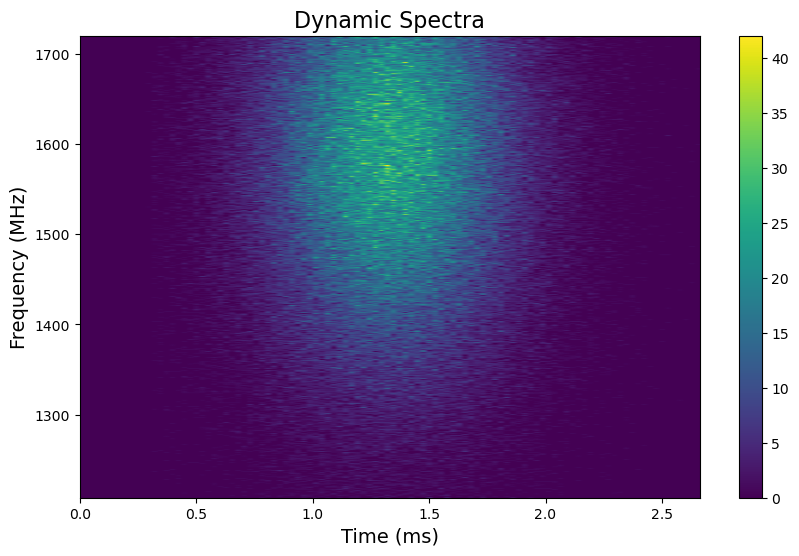

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Maximum value in the pulse: 1.0
Time: 0.0003217645754125577
Frequency: 176.30079365329885
Center Frequency: 1558.5450015778495


In [38]:

sigma_time=generate_sigma_time(0.0008, 0.0004)
sigma_freq=generate_sigma_freq(150, 200)
center_freq=generate_center_freq(1300, 1650)

dm = 0
# create the pulse object
pulse_obj = create.SimpleGaussPulse(
    sigma_time=sigma_time,
    sigma_freq=150,
    center_freq=1600,
    dm=dm,
    tau=0,
    phi=np.pi / 3,
    spectral_index_alpha=0,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    nscint=0,
    bandpass=None,
)

print(center_freq)

# pulse with 3e5 samples
pulse = pulse_obj.sample_pulse(nsamp=int(3e5), dtype=np.float32)
pulse = pulse[:, 208:720]

print(pulse.shape)

plot_dynamic_spectra(pulse)

print(pulse)
pulse = pulse / np.max(pulse)

print(f"Maximum value in the pulse: {np.max(pulse)}")

print(f'Time: {sigma_time}')
print(f'Frequency: {sigma_freq}')
print(f'Center Frequency: {center_freq}')


## Scale the pulse for SNR

In [39]:
scaling_factor = get_scaling_factor(min_value=0.02, max_value=0.4, exponent = -1.5)

print(scaling_factor)

pulse = (pulse * 2).astype(np.float32)

0.04827439728492738


## Inject the Pulse

In [40]:
# Inject the pulse into the dynamic spectrum
dynamic_spectra_with_pulse = inject_pulse_into_dynamic_spectrum(dynamic_spectra, pulse)

## Show injected Pulse

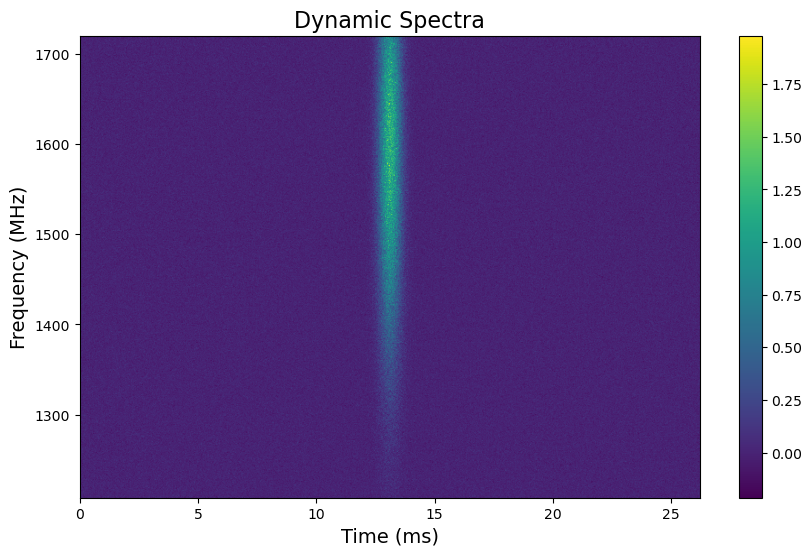

In [41]:
plot_dynamic_spectra(dynamic_spectra_with_pulse)

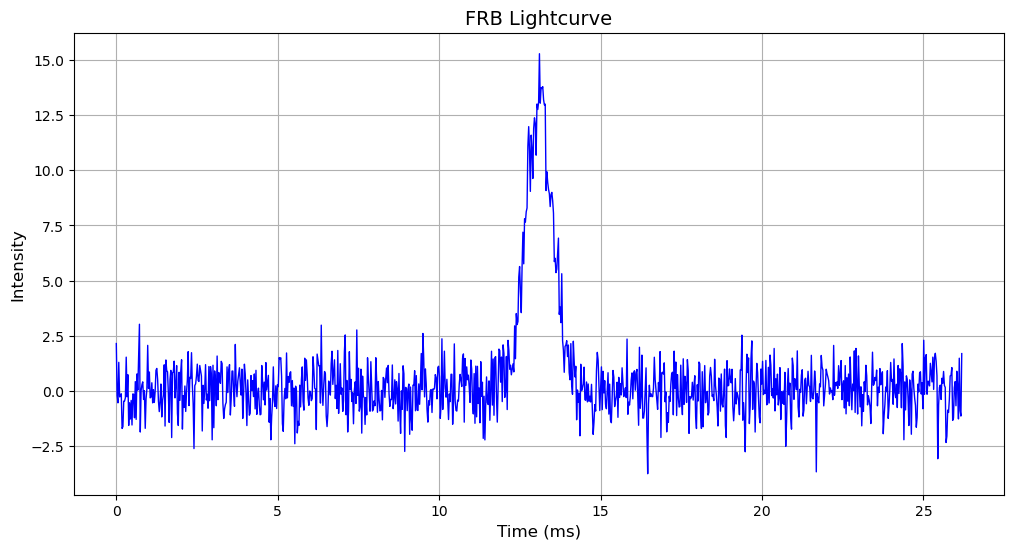

RMS of the noise: 1.024938941001892
15.291975
1.0249387
14.919892
14.9198885


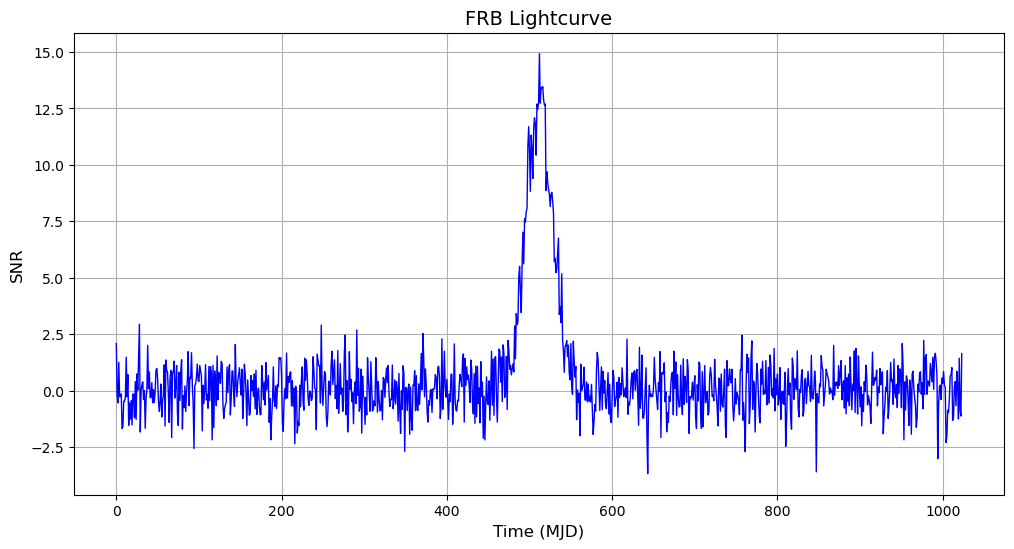

In [139]:
# Sum the frequencies along the frequency axis to get a 1D time series (lightcurve)
lightcurve = np.sum(dynamic_spectra_with_pulse,axis=1)

plot_lightcurve(time_samples=np.arange(1024), lightcurve=lightcurve)

squared_values = lightcurve[0:100] ** 2

# Calculate the mean of the squared values
mean_squared = np.mean(squared_values)

# Take the square root to get the RMS
rms = np.sqrt(mean_squared)

print(f"RMS of the noise: {rms}")

print(np.max(lightcurve))
print(np.std(lightcurve[0:100]))

print(np.max(lightcurve) / np.std(lightcurve[0:100]))

print(np.max(lightcurve)/rms)

# Plot the lightcurve
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1024), lightcurve/np.std(lightcurve[0:100]), color='blue', lw=1)
plt.xlabel("Time (MJD)", fontsize=12)
plt.ylabel("SNR", fontsize=12)
plt.title("FRB Lightcurve", fontsize=14)
plt.grid(True)
plt.show()


## Now for a pulse with a scattering tail

In [4]:
# Create a filterbank with noise, std is such that the lightcurve will have std 1
create_filterbank_with_noise("output_with_noise__2.fil", std_value=np.sqrt(1.0/512), mean_value=0.0, num_frequency_channels=1000, num_time_samples=1024)

# Get the dynamic spectra from a filterbank file with 1024 time samples
dynamic_spectra, yr_obj = get_dynamic_spectra_from_filterbank(file_name='output_with_noise__2.fil', num_time_samples=1024)

# Crop the dynamic spectra
dynamic_spectra = dynamic_spectra[:, 208:720]

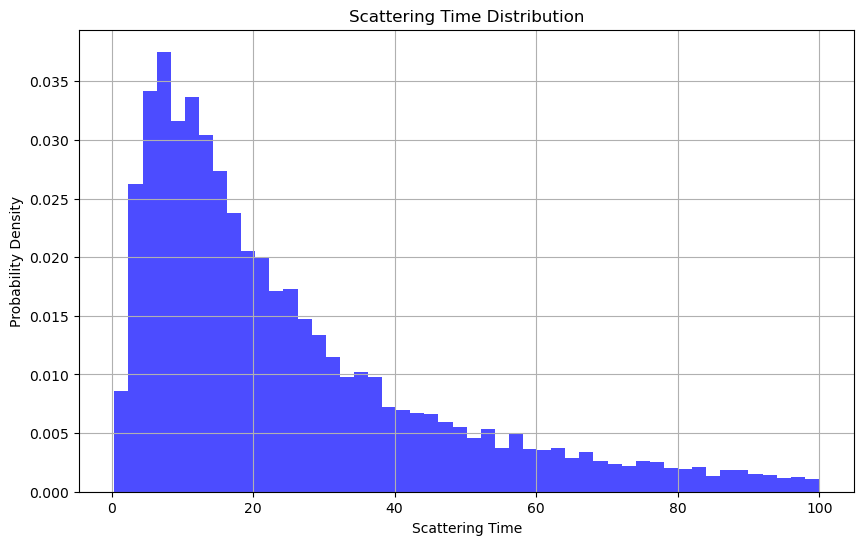

In [44]:
def draw_scattering_time(tau_mean, max_tau):
    """
    Draw a random scattering time from a lognormal distribution.

    Parameters:
        tau_mean (float): Mean of the lognormal distribution.
        max_tau (float): Maximum allowed value for tau.

    Returns:
        float: Random scattering time within the specified range.
    """
    while True:
        tau = np.random.lognormal(tau_mean, 1, 1)
        if tau <= max_tau:
            return np.float64(tau)

# Mean and maximum value for tau
tau_mean = 3
max_tau = 100

# Draw 1000 scattering times
num_samples = 10000
scattering_times = [draw_scattering_time(tau_mean, max_tau) for _ in range(num_samples)]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(scattering_times, bins=50, density=True, alpha=0.7, color='b')
plt.xlabel('Scattering Time')
plt.ylabel('Probability Density')
plt.title('Scattering Time Distribution')
plt.grid(True)
plt.show()


(1208, 512)


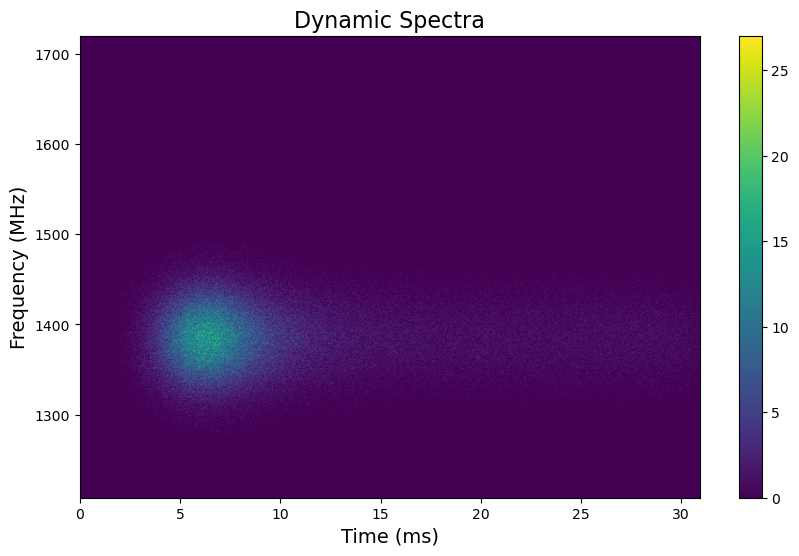

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Maximum value in the pulse: 1.0
Time: 0.0012975696497733143
Frequency: 34.53248234918618
Center Frequency: 1385.685336472729


In [49]:

sigma_time=generate_sigma_time(0.0008, 0.0004)
sigma_freq=generate_sigma_freq(12.5, 100)
center_freq=generate_center_freq(1228, 1700)
scattering_time = generate_scattering_time(3, 100)

dm = 0
# create the pulse object
pulse_obj = create.SimpleGaussPulse(
    sigma_time=sigma_time,
    sigma_freq=sigma_freq,
    center_freq=center_freq,
    dm=dm,
    tau=100,
    phi=np.pi / 3,
    spectral_index_alpha=0,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    nscint=0,
    bandpass=None,
)


# pulse with 3e5 samples
pulse = pulse_obj.sample_pulse(nsamp=int(3e5), dtype=np.float32)
pulse = pulse[:, 208:720]

print(pulse.shape)

plot_dynamic_spectra(pulse)

print(pulse)
pulse = pulse / np.max(pulse)

print(f"Maximum value in the pulse: {np.max(pulse)}")

print(f'Time: {sigma_time}')
print(f'Frequency: {sigma_freq}')
print(f'Center Frequency: {center_freq}')

In [50]:
def inject_scattered_pulse_into_dynamic_spectrum(dynamic_spectra, pulse, pulse_start_time=None):
    """
    Inject a pulse into a dynamic spectrum.

    Parameters:
    - dynamic_spectra (numpy.ndarray): The dynamic spectrum into which the pulse will be injected.
    - pulse (numpy.ndarray): The pulse to inject into the dynamic spectrum.
    - pulse_start_time (int, optional): The time sample where you want to inject the pulse.
      If None (default), it will be placed in the middle of the dynamic spectrum.

    Returns:
    - numpy.ndarray: The dynamic spectrum with the injected pulse.
    """

    # Make a copy of the dynamic spectrum
    dynamic_spectra_copy = dynamic_spectra.copy()

    # Calculate the time sample where you want to inject the pulse
    if pulse_start_time is None:
        pulse_start_time = dynamic_spectra_copy.shape[0] // 4

    # Ensure the dimensions of the pulse match the target region
    desired_shape = dynamic_spectra_copy[pulse_start_time:pulse_start_time + pulse.shape[0], :].shape
    pulse_resized = np.resize(pulse, desired_shape)

    # Inject the resized pulse into the copied dynamic spectrum
    dynamic_spectra_copy[pulse_start_time:pulse_start_time + pulse.shape[0], :] += pulse_resized

    return dynamic_spectra_copy

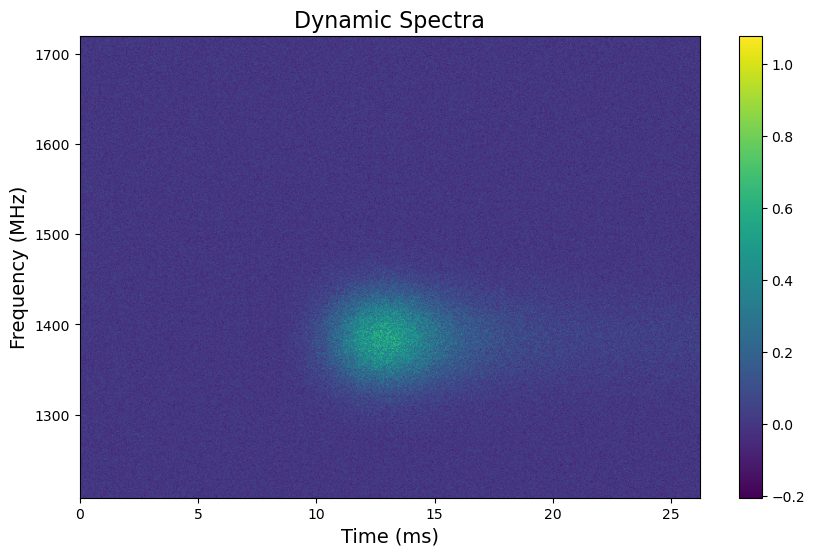

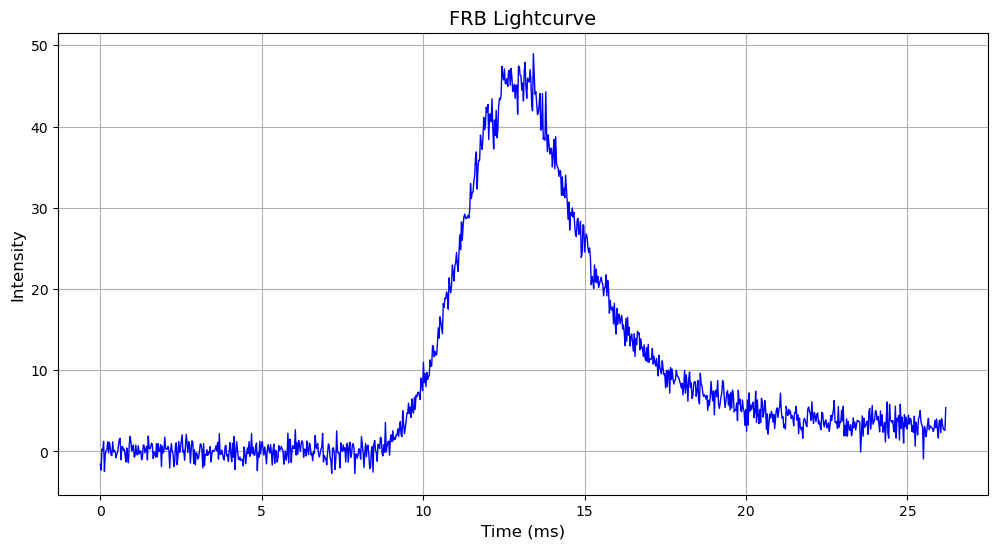

In [51]:
# Inject the pulse into the dynamic spectrum
dynamic_spectra_with_scattered_pulse = inject_scattered_pulse_into_dynamic_spectrum(dynamic_spectra, pulse)

plot_dynamic_spectra(dynamic_spectra_with_scattered_pulse)

lightcurve = np.sum(dynamic_spectra_with_scattered_pulse, axis=1)

plot_lightcurve(time_samples=np.arange(1024), lightcurve=lightcurve)

## Now for a pulse with complex time-frequency structure

In [217]:
# Create a filterbank with noise, std is such that the lightcurve will have std 1
create_filterbank_with_noise("output_with_noise__2.fil", std_value=np.sqrt(1.0/512), mean_value=0.0, num_frequency_channels=1000, num_time_samples=1024)

# Get the dynamic spectra from a filterbank file with 1024 time samples
dynamic_spectra, yr_obj = get_dynamic_spectra_from_filterbank(file_name='output_with_noise__2.fil', num_time_samples=1024)
# Crop the dynamic spectra
dynamic_spectra = dynamic_spectra[:, 208:720]

In [231]:

num_components = np.random.randint(2, 7)  # Random number of components (2 to 6)
dm = 0

sigma_freq = generate_sigma_freq(12.5, 100)
center_freq = generate_center_freq(1228, 1700)

# Generate random parameters for each component
relative_intensities = [1 for _ in range(num_components)]
sigma_times = [generate_sigma_time(0.0008, 0.0004) for _ in range(num_components)]
sigma_freqs = [sigma_freq for _ in range(num_components)]
pulse_thetas = [0 for _ in range(num_components)]
center_freqs = [generate_center_freq(1228, 1700) for _ in range(num_components)]
# Initialize offsets list
offsets = [0.0004]

print(center_freqs)

# Generate offsets based on sigma times distribution
for i in range(1, num_components):
    offset = offsets[-1] + generate_sigma_time(0.0008, 0.0004)  # Offset follows previous component
    offsets.append(offset)

scattering_time = generate_scattering_time(1, 100)


dm_1 = 0
pulse_obj_complex = create.GaussPulse(
    relative_intensities=relative_intensities,
    sigma_times=sigma_times,
    sigma_freqs=sigma_freqs,
    pulse_thetas=pulse_thetas,
    center_freqs=center_freqs,
    dm=dm_1,
    tau=0,
    offsets=offsets,  # all from start of window
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    spectral_index_alpha=0,
    nscint=0,
    phi=np.pi / 3,
    bandpass=None,
)


# Scale the SNR of the pulse according to a power-law distribution
scaling_factor = get_scaling_factor(min_value=0.02, max_value=0.4, exponent=-1.5)

# Generate the pulse signal with the specified parameters
pulse = pulse_obj_complex.sample_pulse(nsamp=int(3e5), dtype=np.float32)

# Crop pulse
pulse = pulse[:, 208:720]

# Normalize before scaling for consistency
pulse = pulse / np.max(pulse)

# Scale the pulse
pulse = (pulse * 2).astype(np.float32)

print(np.max(pulse))


[1365.3201565206618, 1248.6524277291442, 1610.5161362723593]
2.0


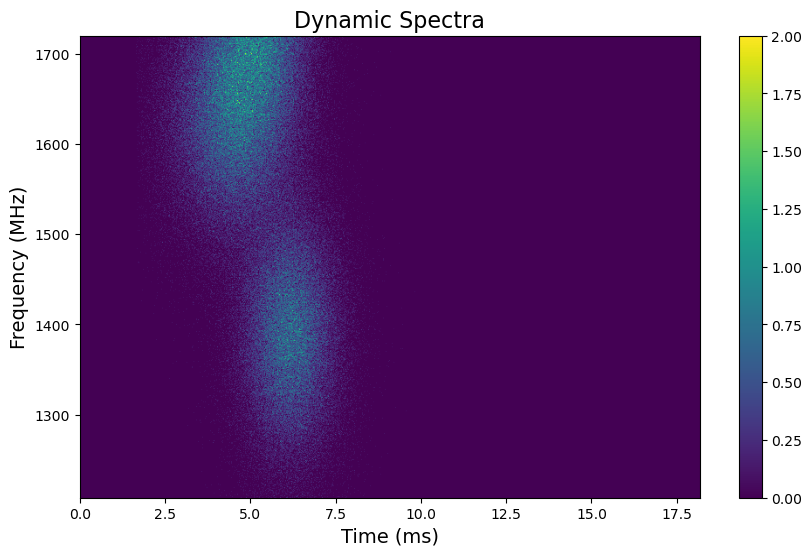

In [232]:
plot_dynamic_spectra(pulse)

In [222]:
def inject_complex_pulse_into_dynamic_spectrum(dynamic_spectra, pulse, pulse_start_time=None):
    """
    Inject a pulse into a dynamic spectrum.

    Parameters:
    - dynamic_spectra (numpy.ndarray): The dynamic spectrum into which the pulse will be injected.
    - pulse (numpy.ndarray): The pulse to inject into the dynamic spectrum.
    - pulse_start_time (int, optional): The time sample where you want to inject the pulse.
      If None (default), it will be placed in the middle of the dynamic spectrum.

    Returns:
    - numpy.ndarray: The dynamic spectrum with the injected pulse.
    """

    # Make a copy of the dynamic spectrum
    dynamic_spectra_copy = dynamic_spectra.copy()

    # Calculate the time sample where you want to inject the pulse
    if pulse_start_time is None:
        pulse_start_time = dynamic_spectra_copy.shape[0] // 3

    # Ensure the dimensions of the pulse match the target region
    desired_shape = dynamic_spectra_copy[pulse_start_time:pulse_start_time + pulse.shape[0], :].shape
    pulse_resized = np.resize(pulse, desired_shape)

    # Inject the resized pulse into the copied dynamic spectrum
    dynamic_spectra_copy[pulse_start_time:pulse_start_time + pulse.shape[0], :] += pulse_resized

    return dynamic_spectra_copy

## Inject the pulse

Maximum value in the spectra: 1.9671388864517212


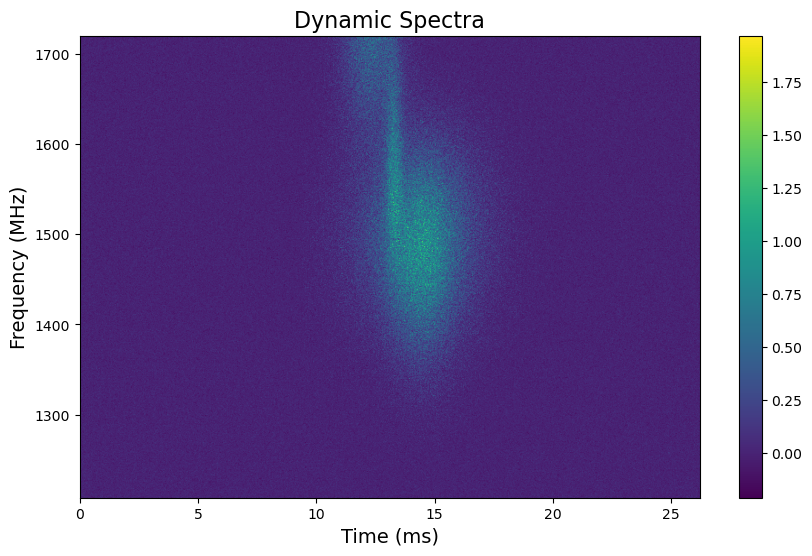

In [223]:
dynamic_spectra_with_complex_pulse = inject_complex_pulse_into_dynamic_spectrum(dynamic_spectra, pulse)

max_value = np.max(dynamic_spectra_with_complex_pulse)

print(f"Maximum value in the spectra: {max_value}")

plot_dynamic_spectra(dynamic_spectra_with_complex_pulse)


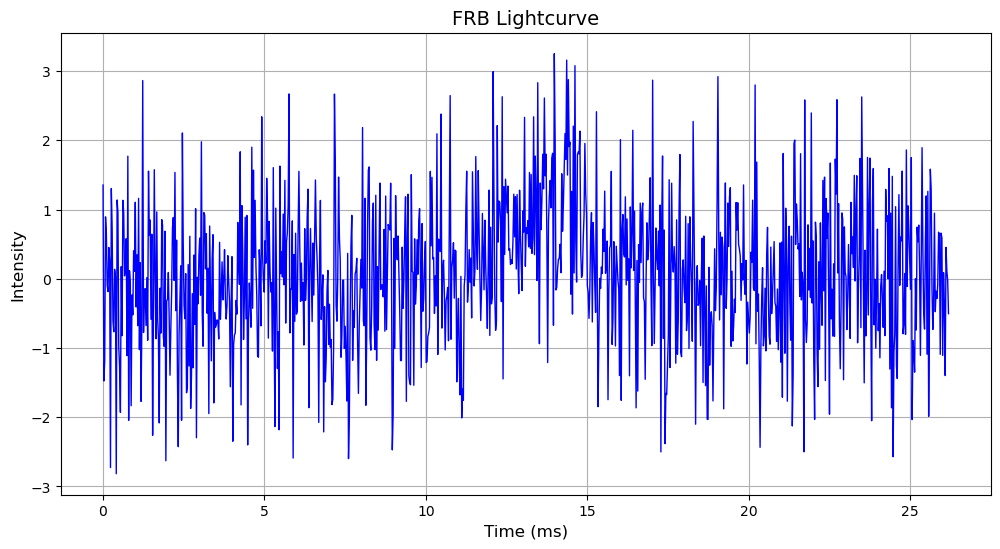

In [172]:
lightcurve_complex = np.sum(dynamic_spectra_with_complex_pulse, axis = 1)

plot_lightcurve(time_samples=(np.arange(1024)), lightcurve=lightcurve_complex)

## Now for a pulse with downward drift

In [238]:
# Create a filterbank with noise, std is such that the lightcurve will have std 1
create_filterbank_with_noise("output_with_noise__2.fil", std_value=np.sqrt(1.0/512), mean_value=0.0, num_frequency_channels=1000, num_time_samples=1024)

# Get the dynamic spectra from a filterbank file with 1024 time samples
dynamic_spectra, yr_obj = get_dynamic_spectra_from_filterbank(file_name='output_with_noise__2.fil', num_time_samples=1024)
# Crop the dynamic spectra
dynamic_spectra = dynamic_spectra[:, 208:720]

In [239]:
num_components = np.random.randint(2, 7)  # Random number of components (2 to 6)
dm = 0

sigma_freq = generate_sigma_freq(12.5, 100)
center_freq = generate_center_freq(1228, 1700)

# Generate random parameters for each component
relative_intensities = [1 for _ in range(num_components)]
sigma_times = [generate_sigma_time(0.0008, 0.0004) for _ in range(num_components)]
sigma_freqs = [sigma_freq for _ in range(num_components)]
pulse_thetas = [0 for _ in range(num_components)]
center_freqs = [center_freq for _ in range(num_components)]
# Initialize offsets list
offsets = [0.0004]

print(center_freqs)

# Generate offsets based on sigma times distribution
for i in range(1, num_components):
    offset = offsets[-1] + generate_sigma_time(0.0008, 0.0004)  # Offset follows previous component
    offsets.append(offset)

drift_rate = 200 # MHz/s

# Calculate the drifts for components 2 and onward
drifts = [0]  # Initialize drifts with zero for the first component
for i in range(1, len(offsets)):
    time_diff_ms = (offsets[i] - offsets[0]) * 1000  # Time difference in ms relative to the first component
    drift = time_diff_ms * drift_rate
    drifts.append(drift)

# Adjust the center frequencies for each component based on the drift
for i in range(1, len(center_freqs)):
    center_freqs[i] += drifts[i]  # Adjust center frequency based on drift

print(center_freqs)

scattering_time = generate_scattering_time(1, 100)


dm_1 = 0
pulse_obj_complex = create.GaussPulse(
    relative_intensities=relative_intensities,
    sigma_times=sigma_times,
    sigma_freqs=sigma_freqs,
    pulse_thetas=pulse_thetas,
    center_freqs=center_freqs,
    dm=dm_1,
    tau=0,
    offsets=offsets,  # all from start of window
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    spectral_index_alpha=0,
    nscint=0,
    phi=np.pi / 3,
    bandpass=None,
)


# Scale the SNR of the pulse according to a power-law distribution
scaling_factor = get_scaling_factor(min_value=0.02, max_value=0.4, exponent=-1.5)

# Generate the pulse signal with the specified parameters
pulse = pulse_obj_complex.sample_pulse(nsamp=int(3e5), dtype=np.float32)

# Crop pulse
pulse = pulse[:, 208:720]

# Normalize before scaling for consistency
pulse = pulse / np.max(pulse)

# Scale the pulse
pulse = (pulse * 2).astype(np.float32)

print(np.max(pulse))


[1375.3746431893414, 1375.3746431893414, 1375.3746431893414, 1375.3746431893414]
[1375.3746431893414, 1631.7390446091304, 1790.5253208889872, 1918.1021310952876]
2.0


Maximum value in the spectra: 2.0806586742401123


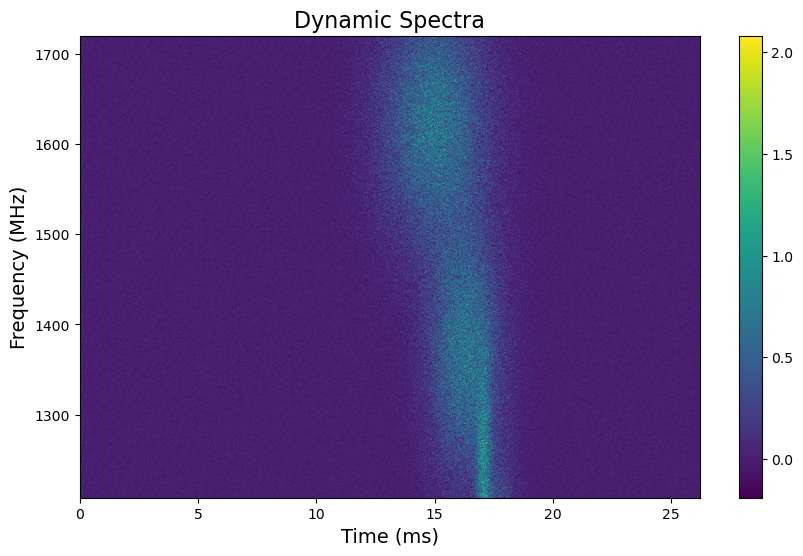

In [240]:
dynamic_spectra_with_complex_pulse = inject_complex_pulse_into_dynamic_spectrum(dynamic_spectra, pulse)

max_value = np.max(dynamic_spectra_with_complex_pulse)

print(f"Maximum value in the spectra: {max_value}")

plot_dynamic_spectra(dynamic_spectra_with_complex_pulse)

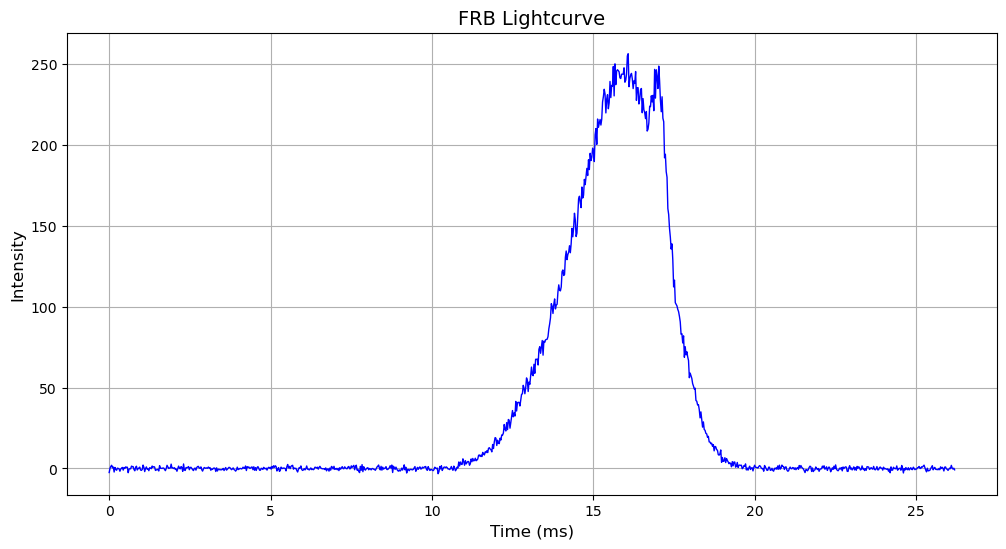

In [241]:
lightcurve_complex = np.sum(dynamic_spectra_with_complex_pulse, axis = 1)

plot_lightcurve(time_samples=(np.arange(1024)), lightcurve=lightcurve_complex)